In [182]:
%pylab inline
from snakebite.client import Client
import pyaml as yaml
import sys
import pythonrun
reload(pythonrun)
import os
import seaborn as sns
from sklearn import metrics
import scala_python_endive_wrapper
reload(scala_python_endive_wrapper)
from scala_python_endive_wrapper import *
import pandas as pd
import os
import re

Populating the interactive namespace from numpy and matplotlib


In [172]:
hdfsclient = Client("amp-spark-master.amp", 8020, use_trash=False)
notebook_stdout = sys.stdout
notebook_stderr = sys.stderr
terminal_stdout = open('/dev/stdout', 'w')
terminal_stderr = open('/dev/stderr', 'w')


In [173]:
executor_mem = "100g"
cores_per_executor = 30
num_executors = 14

In [ ]:
# this is where the magic happens
val_results = []
train_results = []
for num_feats in [256, 1024, 4096]:
    for reg in [1e-2, 1e-1, 1.0]:
        gamma = 1.0
        params = {"num_feats":num_feats, "gamma":gamma, "reg":reg}
        print("COMPUTING EXPERIMENT FOR {0}".format(params))
        train_df, val_df = run_deepsea_pipeline(['Egr-1', 'ATF3'], hdfs=hdfsclient, run_solver_only=True, gamma=gamma, reg=reg, num_filters=num_feats)
        train_result = compute_results(train_df, "train_", params)
        val_result = compute_results(val_df, "val_", params, control_rocs=control_rocs, control_prs=control_prs)
        val_results.append(val_result)
        train_results.append(train_result)
        print(train_result)
        print(val_result)
    
    

COMPUTING EXPERIMENT FOR {'num_feats': 256, 'reg': 0.01, 'gamma': 1.0}
False
/user/vaishaal/800_8_256_1.0_train.features


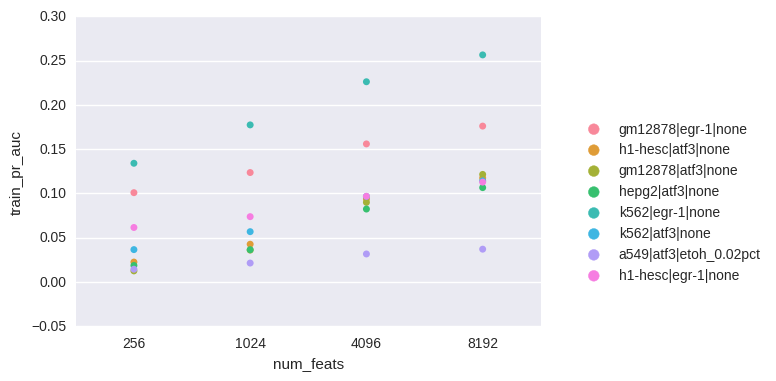

In [152]:
sns.stripplot(y="train_pr_auc", x="num_feats", hue="meta", data=pd.concat(train_results))
plt.legend(bbox_to_anchor=(1.5, 0.7))

In [101]:
def compute_results(df, tag, params={}, control_rocs={}, control_prs={}):
    metas = list(set(map(lambda x:  re.sub(r"(_label|_score).*", "", x), train_df.columns.values)))
    results = []
    for m in metas:
        result = {} 
        score_column = m + "_score"
        label_column = m + "_label"
        y_pred = df[score_column]
        y_true = df[label_column]
        roc_auc = metrics.roc_auc_score(y_true, y_pred)
        pr_auc = metrics.average_precision_score(y_true, y_pred)
        result[tag + 'roc_auc'] = roc_auc
        result[tag + 'pr_auc'] = pr_auc
        if (control_rocs != {}):
            result["control_roc_auc"] = control_rocs[m.lower()]
        if (control_prs != {}):
            result["control_pr_auc"] = control_prs[m.lower()]
            
        result['meta'] = m.lower()
        result = dict(result.items() + params.items())
        results.append(result)
    return pd.DataFrame(results)

In [116]:
res = compute_results(val_df, "val_", control_rocs=control_rocs, control_prs=control_prs)

In [117]:
res[['meta','val_roc_auc','control_roc_auc', 'val_pr_auc', 'control_pr_auc']]

,meta,val_roc_auc,control_roc_auc,val_pr_auc,control_pr_auc
0,gm12878|egr-1|none,0.989779,0.996045,0.218564,0.343724
1,k562|egr-1|none,0.874620,0.958207,0.192677,0.334479
2,h1-hesc|egr-1|none,0.829175,0.950912,0.096637,0.169983


In [95]:
cols = res.columns.tolist()

In [97]:
res[cols]

,control_pr,control_roc,meta,val_pr_auc,val_roc_auc
0,0.496891,0.973567,k562|atf3|none,0.015329,0.792868
1,0.368892,0.993995,hepg2|atf3|none,0.018572,0.746247
2,0.086962,0.995998,h1-hesc|atf3|none,0.004463,0.916802
3,0.280633,0.934871,a549|atf3|etoh_0.02pct,0.032828,0.661457
4,0.003497,0.964491,gm12878|atf3|none,0.000351,0.646599


(0, 1.0)

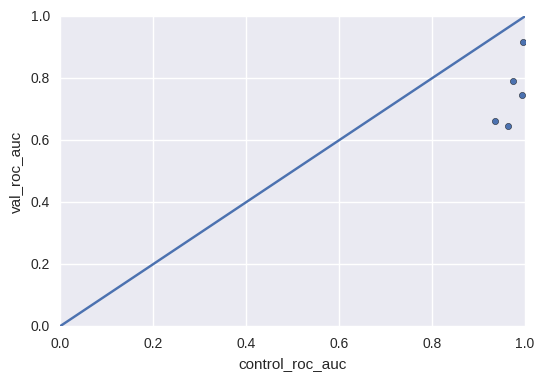

In [114]:
res.plot(kind="scatter", y="val_roc_auc", x="control_roc_auc")
plt.plot( [0,1],[0,1] )
plt.xlim(0,1.0)
plt.ylim(0,1.0)


In [70]:
control_df = pd.read_csv("/home/eecs/vaishaal/deepsea_data/deepsea_control_results_eval.csv")

In [81]:
control_rocs = {}
control_prs = {}
for c in control_df.itertuples():
   meta_key = "{0}|{1}|{2}".format(c[1], c[2], c[3]).lower() 
   control_rocs[meta_key] = c[4]
   control_prs[meta_key] = c[5]

{'a549|atf3|etoh_0.02pct': 0.9348709999999999,
 'a549|bcl3|etoh_0.02pct': 0.87106399999999995,
 'a549|bhlhe40|none': 0.9899969999999999,
 'a549|cebpb|none': 0.96548899999999993,
 'a549|creb1|dex_100nm': 0.97547299999999992,
 'a549|ctcf|dex_100nm': 0.98537700000000006,
 'a549|ctcf|etoh_0.02pct': 0.98688700000000007,
 'a549|ctcf|none': 0.98180499999999993,
 'a549|ctcf|none.1': 0.97897000000000012,
 'a549|elf1|etoh_0.02pct': 0.95544400000000007,
 'a549|ets1|etoh_0.02pct': 0.99270300000000011,
 'a549|fosl2|etoh_0.02pct': 0.93585400000000007,
 'a549|foxa1|dex_100nm': 0.91710300000000011,
 'a549|gabp|etoh_0.02pct': 0.94045200000000007,
 'a549|gr|dex_100nm': 0.94170100000000001,
 'a549|gr|dex_500pm': 0.94843600000000006,
 'a549|gr|dex_50nm': 0.89539299999999999,
 'a549|gr|dex_5nm': 0.91405599999999998,
 'a549|max|none': 0.9581940000000001,
 'a549|nrsf|etoh_0.02pct': 0.92365300000000006,
 'a549|p300|etoh_0.02pct': 0.87739299999999998,
 'a549|pol2(phosphos2)|none': nan,
 'a549|pol2|dex_100nm': 